In [92]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

s = 6 # index of the simulation we want to have a closer look on
s_inlist = s -  #adjusted index in case
tw_s = [10, 10, 10, 10, 20, 20] # time window lengths in the simulated data
tw = tw_s[s] 


#----------------------------------------------------------------------------------
# Read data from different simulations into list according to invm & useKG settings
#----------------------------------------------------------------------------------

np_t = [] # list for outputs with settings. invm = numpy.linalg.inv, useKG = True
np_f = [] # invm = np.linalg.inv, useKG = False
bl_t = [] # invm = block_inv, useKG = True
bl_f = [] # invm = block_inv, useKG = False

#!!!!!!!!!!!!!!!!
# These loops need to be changed for situations in which not all simulations starting from 00 are read! Maybe turn into a function?

#loop through simulations, read all but matrices from the data
for i in range(9):
    if i < s:
        np_t.append(xr.Dataset())
    else: 
        np_t.append(xr.open_mfdataset(f"simulated_data/simulation_0{i}/out_default_with_kf/*.nc",
                                    concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))

    # bl_t.append(xr.open_mfdataset(f"simulated_data/simulation_0{i}/out1_block_with_kf/*.nc",
    #                     concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))

    # np_f.append(xr.open_mfdataset(f"simulated_data/simulation_0{i}/out1_default_without_kf/*.nc",
    #                                 concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))
    
    # bl_f.append(xr.open_mfdataset(f"simulated_data/simulation_0{i}/out1_block_without_kf/*.nc",
    #                                 concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))

#------------------------------------------------------------------------------
# Had to read matrices in another way, as open_mfdataset didn't work with them
#----------------------------------------------------------------------------

def read_matrices(sim, subfilename):
    """Helper function to read output matrices from simulation instance sim.
    """
    B = [] # prior covariance matrices
    A = [] # posterior covariance matrices
    R = [] # observation error covariance matrices

    for i in range(5):
        filepath = f"simulated_data/simulation_0{sim}/{subfilename}/s0{sim}_out_0{i}.nc"
        data = xr.open_dataset(filepath)
        B.append(data["prior_cov"])
        A.append(data["posterior_cov"])
        R.append(data["obs_unc"])
    return B, A, R

B_np, A_np, R_np = read_matrices(s, 'out1_default_with_kf')
B_bl, A_bl, R_bl = read_matrices(s, "out1_block_with_kf")

for i in range(5):
    print(np_t[i])

<xarray.Dataset>
Dimensions:      (time: 50, time2: 5, nstate: 10)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: time2, nstate
Data variables:
    prior        (time2, nstate) float64 dask.array<chunksize=(1, 10), meta=np.ndarray>
    posterior    (time2, nstate) float64 dask.array<chunksize=(1, 10), meta=np.ndarray>
    obs          (time2, time) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
    differences  (time2, time) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
Attributes:
    comments:  Fixed version of H. Matrix inverse function: inv from module: ...
<xarray.Dataset>
Dimensions:      (time: 50, time2: 5, nstate: 50)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: time2, nstate
Data variables:
    prior        (time2, nstate) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
    posterior    (time2, 

In [93]:
#let's look at the settings in the initial data in the chosen time window
data = np_t[s]
print(data)

<xarray.Dataset>
Dimensions:      (time: 50, time2: 5, nstate: 500)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: time2, nstate
Data variables:
    prior        (time2, nstate) float64 dask.array<chunksize=(1, 500), meta=np.ndarray>
    posterior    (time2, nstate) float64 dask.array<chunksize=(1, 500), meta=np.ndarray>
    obs          (time2, time) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
    differences  (time2, time) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
Attributes:
    comments:  Fixed version of H. Matrix inverse function: inv from module: ...


Posterior state
----------------

Changes so small that if I try to plot all nstates in the same plot, changes won't show, because plot will be too much zoomed out.
Better to plot one at a time as an example / sanity check

[23 30 16 24 48 44 37 10 17]


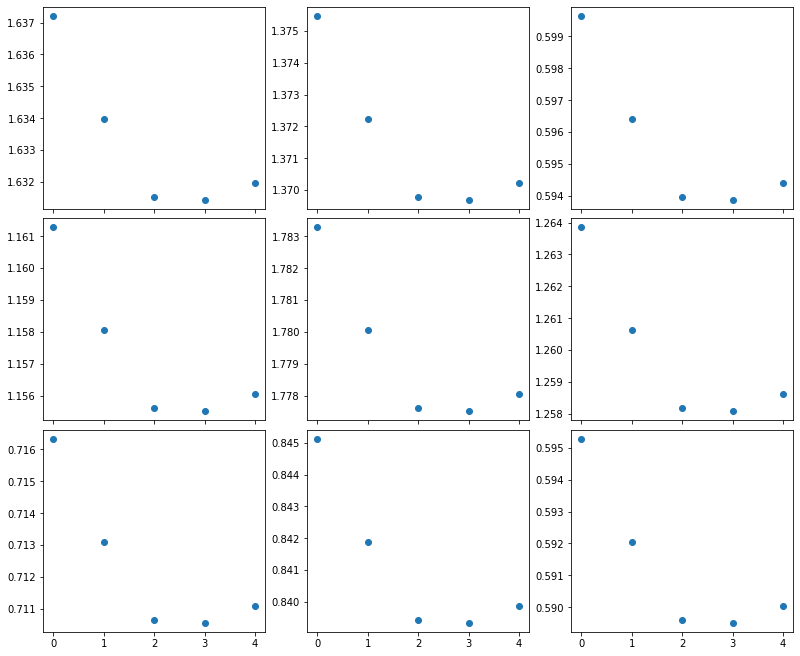

In [83]:
nstate = data.dims['nstate']
post = data.posterior

states = np.random.randint(nstate, size = 9) #pick a couple of random states to look at
print(states)
selection = []
for i in range(9):
    selection.append(post.isel(nstate = states[i]))




fig, axs = plt.subplots(3,3, figsize = (11,9), layout = 'constrained', sharex = 'col')
for k in range(9):
    i = k // 3
    j = k - 3*i
    axs[i,j].plot(selection[k], 'o') # marker = 'o', color = 'red', alpha = 0.7)
plt.show()


Observations
--------------

Text(0.5, 1.0, 'Observations (s01)')

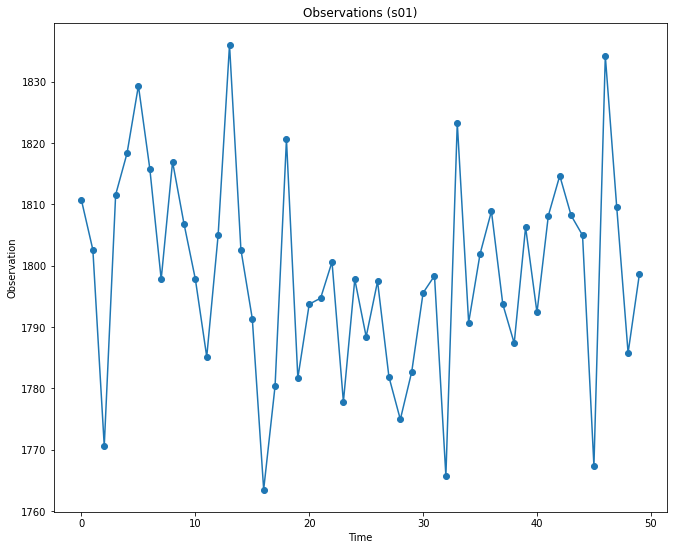

In [84]:
obs_by_tw = data.obs
ls = []
for i in range(5):
    ls.append(obs_by_tw[i,i*tw:(i+1)*tw])
obs = xr.concat(ls, dim = 'time')

fig, ax = plt.subplots(figsize = (11,9))
ax.plot(obs, marker= 'o')
ax.set_xlabel('Time')
ax.set_ylabel('Observation')
ax.set_title(f'Observations (s0{s})')


Obs - prior differences
-----------------------
Below plotted for the whole time, including the first time window, in which
differences significantly larger.

Maybe better to exclude the first time window from the plot?

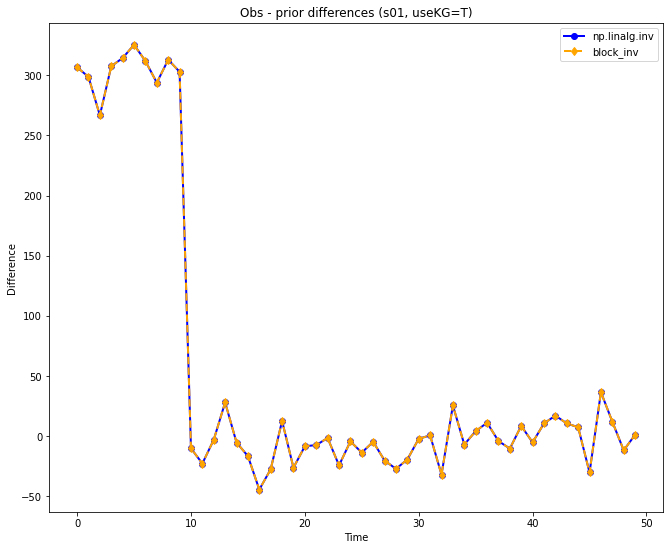

In [85]:
#-----------------------------------------------------
# Change data into a more suitable format for plotting 
#-----------------------------------------------------


# E.g. in s01 data.differences of each timewindow have shape (1,50) even though
# the actual time window is shorter than 50. Let's pick the slice of 
# the total time that corresponds to each time window (shape (1.10)) and 
# recombine these slices into a single dataArray of shape (1,50)


# obs - prior differences from simulation s

da1 = data.differences 
da2 = bl_t[s].differences
da3 = np_f[s].differences
da4 = bl_f[s].differences 


# arrange data from the different time windows ('time2') into one long time window

ls1 = []
ls2 = []
ls3 = []
ls4 = []

for i in range(5):
    ls1.append(da1[i,i*tw:(i+1)*tw])
    ls2.append(da2[i,i*tw:(i+1)*tw])
    ls3.append(da3[i,i*tw:(i+1)*tw])
    ls4.append(da4[i,i*tw:(i+1)*tw])
np_t_dif = xr.concat(ls1, dim = 'time')
bl_t_dif = xr.concat(ls2, dim = 'time')
np_f_dif = xr.concat(ls3, dim = 'time')
bl_f_dif = xr.concat(ls4, dim = 'time')

fig, ax = plt.subplots(figsize = (11,9))
ax.plot(np_t_dif, linewidth = 2, color = 'blue', marker = 'o', label = "np.linalg.inv")
ax.plot(bl_t_dif, linewidth = 2, linestyle = 'dashed', color = 'orange', marker = 'd', label = "block_inv")
ax.set_xlabel("Time")
ax.legend()
ax.set_ylabel("Difference")
ax.set_title(f"Obs - prior differences (s0{s}, useKG=T)")

diff_prior = np_t_dif

# plt.show()



#--------------------------------------------------------------------------------------
# Plot with discontinuous y-axis for the case with the old dummy observation operator H
#--------------------------------------------------------------------------------------

#split y-axis into two by creating two subplots on
# top of each other
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize = (11,9))
# fig.subplots_adjust(hspace=0.08)

# # same data on both axes
# ax1.plot(np_t_dif, linewidth = 2, color = 'blue', marker = 'o', label = "np.linalg.inv")
# ax2.plot(np_t_dif, linewidth = 2, color = 'blue', marker = 'o', label = "np.linalg.inv")
# ax1.plot(bl_t_dif, linewidth = 2, linestyle = 'dashed', color = 'orange', marker = 'd', label = "block_inv") 
# ax2.plot(bl_t_dif, linewidth = 2, linestyle = 'dashed', color = 'orange', marker = 'd', label = "block_inv")


# # dashed line at zero
# ax1.axhline(y=0,linewidth= 1, color='grey', linestyle= 'dashed')

# minval = np_t_dif.values.min()
# maxval = np_t_dif.values.max()


# # zoom-in / limit the view to different portions of the data
# ax1.set_ylim(-maxval-5, maxval+5)  # most of the data
# ax2.set_ylim(-8.9659*1e5, -8.965*1e5)  # outliers only

# # hide the spines between ax and ax2
# ax1.spines.bottom.set_visible(False)
# ax2.spines.top.set_visible(False)
# ax1.xaxis.tick_top()
# ax1.tick_params(labeltop=False)  # don't put tick labels at the top
# ax2.xaxis.tick_bottom()
# ax2.ticklabel_format(useOffset=False)

# # cut-out slanted lines.
# # We create line objects in axes coordinates, in which (0,0), (0,1),
# # (1,0), and (1,1) are the four corners of the axes.

# d = .5  # proportion of vertical to horizontal extent of the slanted line
# kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
#               linestyle="none", color='k', mec='k', mew=1, clip_on=False)
# ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
# ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# ax2.set_xlabel("Time")
# ax2.legend()
# ax1.set_ylabel("Difference")
# ax1.set_title(f"Obs - prior differences (s0{s}, useKG=T)")



# plt.show()




In [86]:
post = data.posterior
prior = data.prior

for i in range(5):    
    diff_po_pri = post[i,0]-prior[i,0:2]
    print(diff_po_pri.values)

[ 0.16896647 -0.96109166]
[-0.00322826 -1.13328638]
[-0.00244752 -1.13250564]
[-8.82539972e-05 -1.13014638e+00]
[ 5.26710855e-04 -1.12953141e+00]


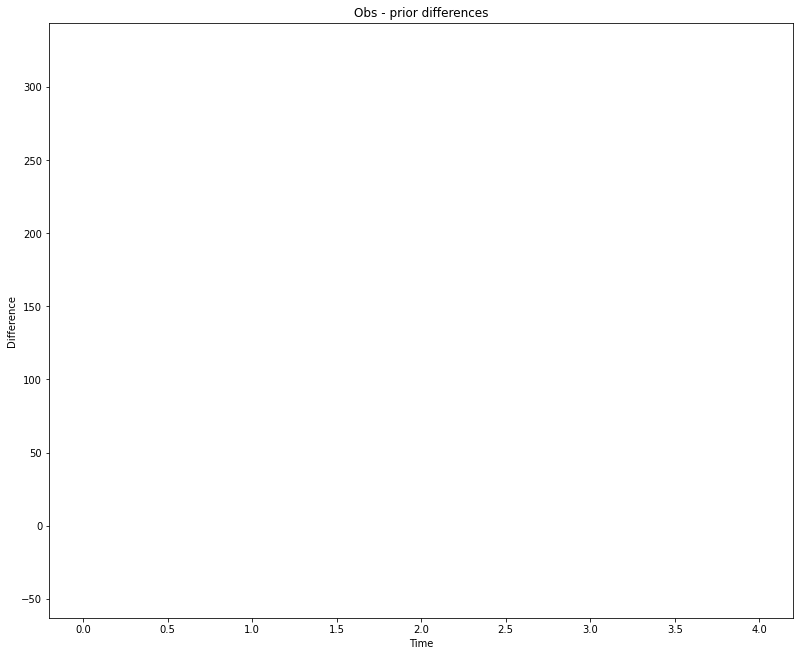

In [87]:
prior_dif = np_t[s].differences
fig, ax = plt.subplots(layout = 'constrained', figsize = (11,9))
ax.plot(prior_dif)
ax.set_ylabel('Difference')
ax.set_xlabel('Time')
ax.set_title('Obs - prior differences')
plt.show()


Obs - posterior differences
-----------------------------

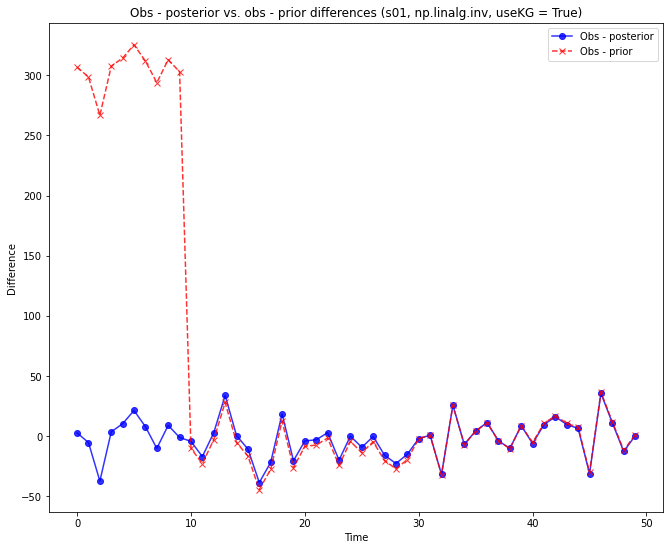

In [89]:
xa = data.posterior.values
#xa1 = bl_t[s].posterior.values.flatten()
y = obs

nobs = len(y)
nstate = len(data.nstate)
t = data.time.values 
ntw = data.dims['time2'] #number of timesteps
tw = int(len(t)/ntw) # length of time window


H = np.ones((nobs,nstate))*1800/nstate

ls_diff = []
for timestep in range( int(len(t)/tw) ): #Loop through time
    # Select observational data for this time 
    w = np.where((t>=timestep*tw)&(t<timestep*tw+tw))[0]
    y_t = y[w]
    xa_t = xa[timestep,:]
    H_t= H[w,:]
        
    diff_t = y_t - H_t.dot(xa_t)
    ls_diff.append(diff_t)

diff_post = xr.concat(ls_diff, dim = 'time')

fig, ax = plt.subplots(figsize = (11,9))
ax.plot(diff_post, marker = 'o', color = 'blue', alpha = 0.8, label = "Obs - posterior")
ax.plot(diff_prior, marker = 'x', color = 'red', linestyle = 'dashed', alpha = 0.8, label = "Obs - prior")
ax.set_xlabel("Time")
ax.set_ylabel("Difference")
ax.legend()
ax.set_title(f"Obs - posterior vs. obs - prior differences (s0{s}, np.linalg.inv, useKG = True)")
plt.show()

Covariance and observation uncertainty matrices
------------------------------------------------

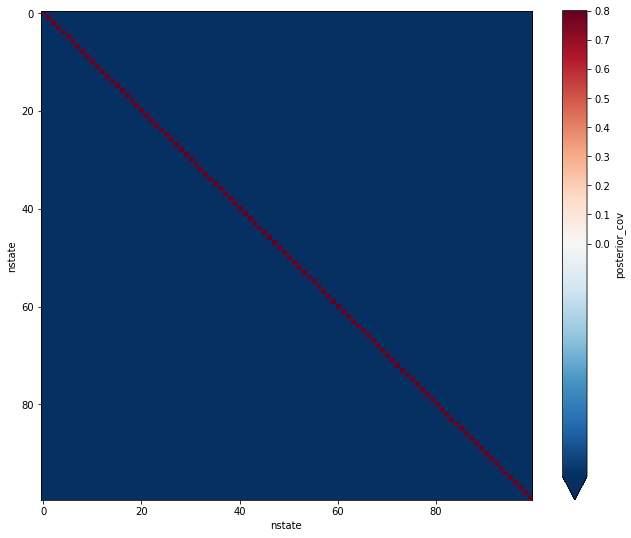

In [ ]:
M = A_np[s]

qlower = np.quantile(M, 0.01)
qupper = np.quantile(M, 0.99)

fig, ax = plt.subplots(figsize = (11,9))
norm = colors.TwoSlopeNorm(vmin = min(0,qlower), vcenter = 0, vmax = max(0.8,qupper))
M.plot.imshow(ax=ax, yincrease = False, norm = norm)
plt.show()


Multiple subplots in same figure

* turns out the colorbar normalation is tricky


The easiest but ugliest way out: each subplot has its own colorbar, and colorbar ranges differ.


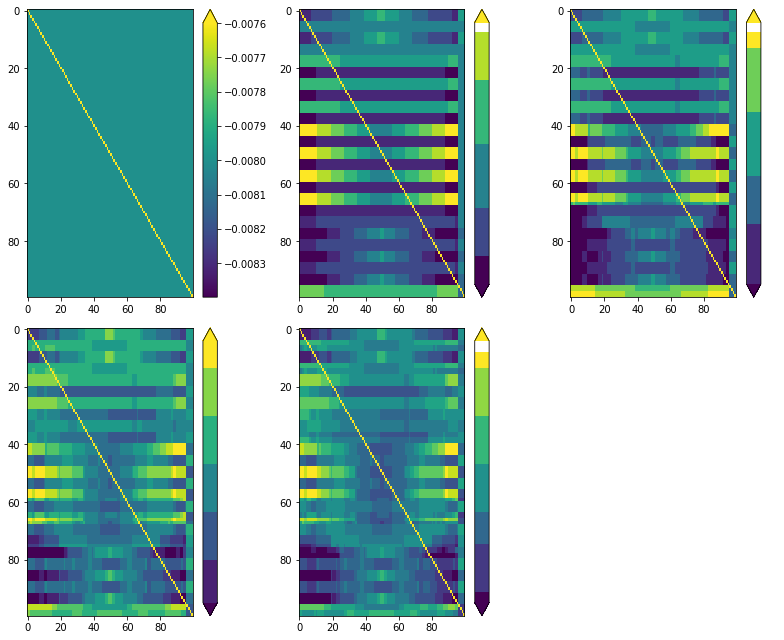

In [ ]:

fig, axs = plt.subplots(2,3, figsize = (11,9))
axs[-1,-1].axis('off')
for k in range(5):
    i = k // 3
    j = k - 3*i
    A_np[k].plot.imshow(ax = axs[i,j], yincrease = False, add_labels = False, robust = True)
plt.tight_layout()
plt.show()



QUANTILES + SYMLOGNORM

Problem with SymLogNorm: plots a really nice plot but the colormap doesn't center at zero

Colorbar min and max set manually to certain quantiles.
Alfa has to be really small < 10**(-3) 
Otherwise all but the first subplot seem to become uniformly one color
because such an immense part of the values within very small range around zero


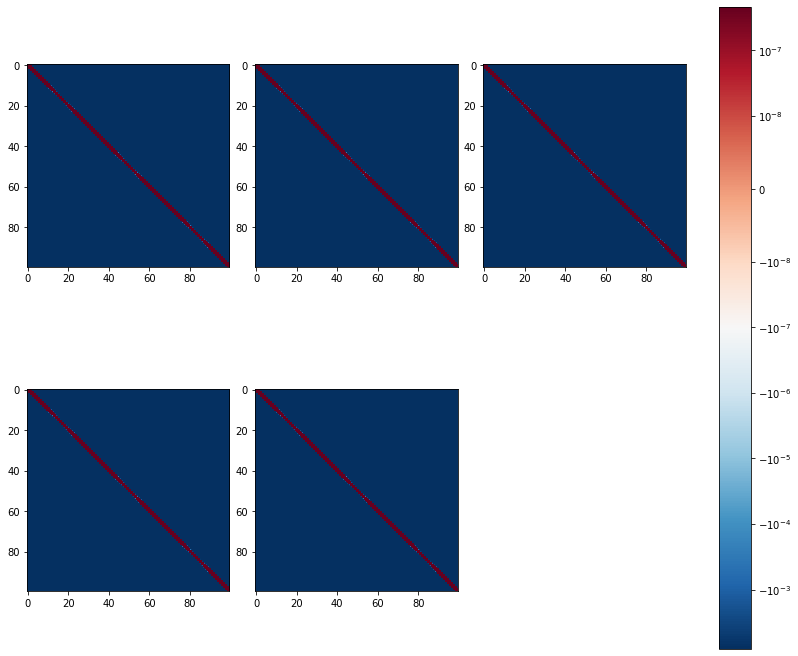

In [ ]:

fig, axs = plt.subplots(2,3, figsize = (11,9), layout = 'constrained')
axs[-1,-1].axis('off')

images = []
for k in range(5):
    i = k // 3
    j = k - 3*i
    images.append(axs[i,j].imshow(A_np[k], cmap = 'RdBu_r'))
    #axs[i, j].label_outer()

# Find the quantiles to use as colorbar min and max

    
qlower = min(np.quantile(A.values, 0.01) for A in A_np)
qupper = max(np.quantile(A.values, 0.99) for A in A_np)
vmin = min(A.values.min() for A in A_np)
vmax = max(A.values.max() for A in A_np)

norm = colors.SymLogNorm(vmin=qlower, vmax = qupper, linthresh = 10**(-8))
for im in images:
    im.set_norm(norm)

fig.colorbar(im, ax=axs.ravel().tolist(), norm = norm)
plt.show()


-0.007999907408479287 4.629363420712712e-07


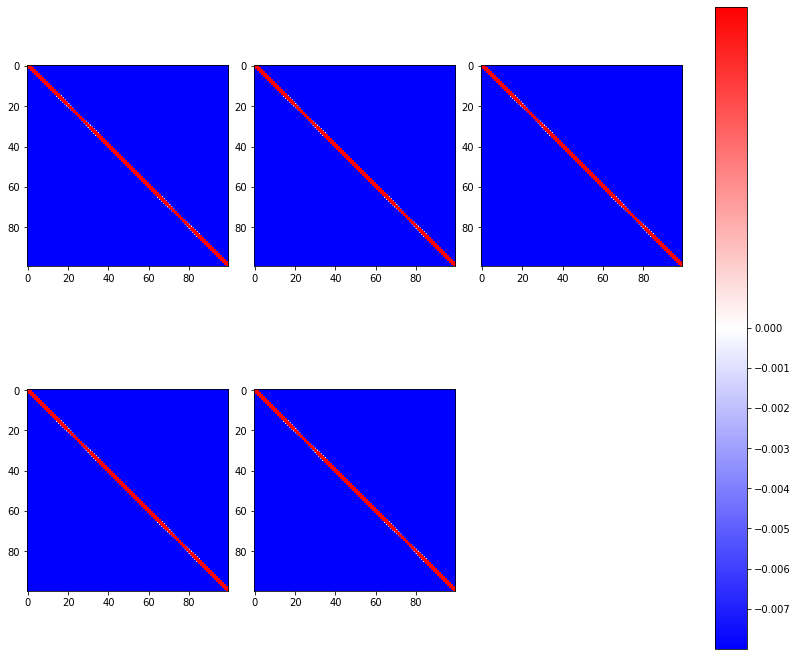

In [ ]:

qlower = min(np.quantile(A.values, 0.01) for A in A_np)
qupper = max(np.quantile(A.values, 0.99) for A in A_np)
vmin = min(A.values.min() for A in A_np)
vmax = max(A.values.max() for A in A_np)
print(qlower, qupper)

ig, axs = plt.subplots(2,3, figsize = (11,9), layout = 'constrained')
axs[-1,-1].axis('off')

images = []
for k in range(5):
    i = k // 3
    j = k - 3*i
    images.append(axs[i,j].imshow(A_np[k], cmap = 'bwr'))
    #axs[i, j].label_outer()

norm = colors.TwoSlopeNorm(vcenter = 0.0, vmin = qlower, vmax = qupper)

#from normalize_midpoint import MidpointNormalize
#norm = MidpointNormalize(vmin=qlower, vmax=qupper, midpoint=0)
#norm = colors.SymLogNorm(vmin=qlower, vmax = qupper, linthresh = 10**(-8))
for im in images:
    im.set_norm(norm)

fig.colorbar(im, ax=axs.ravel().tolist(), norm = norm)
plt.show()



From stackexchange: 

This is for the more complex case where the values are not just between 0 and 1; the cmap needs to be shared instead of just using the last one.


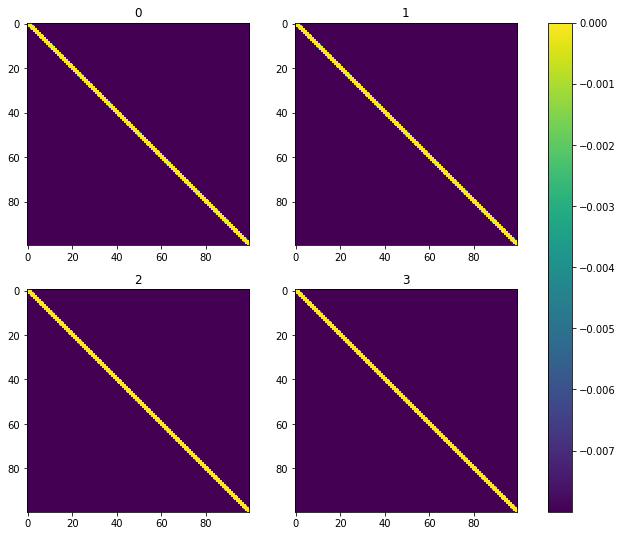

In [ ]:



import matplotlib.cm as cm
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (11, 9))
cmap=cm.get_cmap('viridis')
normalizer=colors.Normalize(qlower, qupper)
im=cm.ScalarMappable(norm=normalizer, cmap = cmap)
for i,ax in enumerate(axes.flat):
    ax.imshow(A_np[i],cmap=cmap,norm=normalizer)
    ax.set_title(str(i))
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

Another one from stackexchange

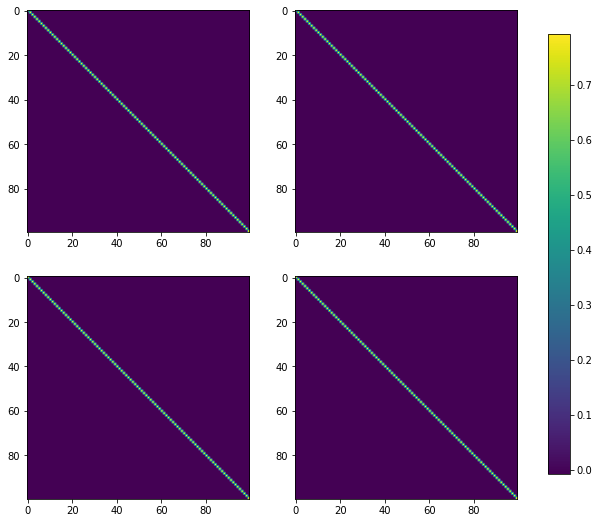

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (11,9))
i = 1
for ax in axs.flat:
    plt.sca(ax)
    plt.imshow(A_np[i], cmap='viridis')
    i += 1
plt.colorbar(ax=axs.ravel().tolist(), shrink=0.9)
plt.show()




How about matshow?



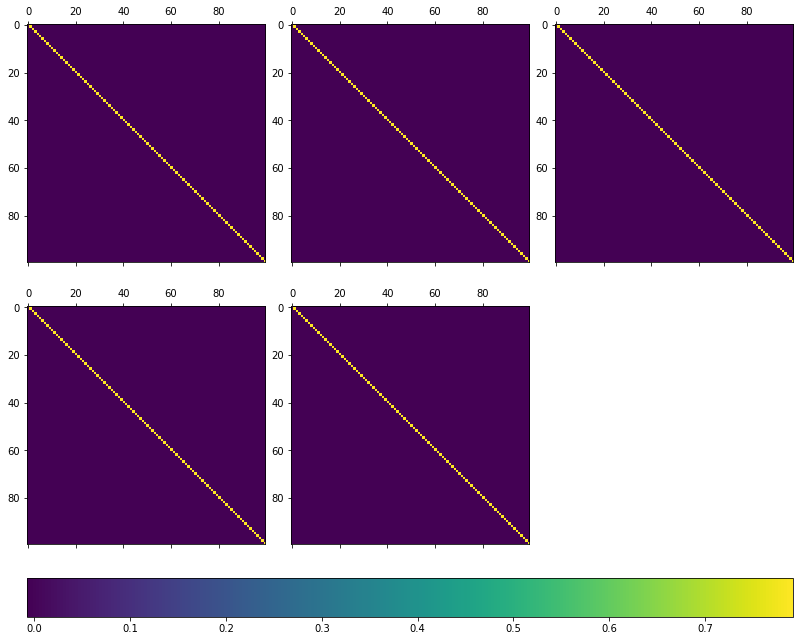

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (11,9), layout = 'constrained')
axes[-1,-1].axis('off')
for k in range(5):
    i = k // 3
    j = k - 3*i
    im = axes[i,j].matshow(A_np[k])

fig.colorbar(im, ax=axes.ravel().tolist(), norm = colors.Normalize(vmin = vmin, vmax = vmax), location = 'bottom')

plt.show()